In [1]:
import re

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from feature_engine.outliers import ArbitraryOutlierCapper
import warnings

warnings.filterwarnings("error")

In [2]:
seed = 48

In [3]:
tar_features = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
tar_sd_features = ['X4_sd', 'X11_sd', 'X18_sd', 'X50_sd', 'X26_sd', 'X3112_sd']
log_features = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [4]:
train = pd.read_csv('./data/train.csv', index_col='id').fillna(0)
sub = pd.read_csv('./data/sample_submission.csv', index_col='id')
# train = train + 1e-5

In [5]:
train_xs, valid_xs = train_test_split(train, test_size=0.2, random_state=seed)
train_xs.shape, valid_xs.shape

((44391, 175), (11098, 175))

In [6]:
train_xs[tar_features].describe().T

,count,mean,std,min,25%,50%,75%,max
X4_mean,44391.0,0.522885,1.758845e-01,-2.431157e+00,0.411067,0.508919,0.622760,4.475172e+00
X11_mean,44391.0,159.569755,1.428773e+04,6.780000e-05,10.626319,15.116270,19.680132,1.504254e+06
X18_mean,44391.0,24578.633284,2.582359e+06,2.330000e-08,0.313851,0.720825,3.635854,2.720494e+08
X50_mean,44391.0,12.802032,1.313423e+03,9.680000e-05,1.172768,1.478612,1.926010,1.597599e+05
X26_mean,44391.0,3597.055443,2.623069e+05,5.500000e-07,0.572460,2.539143,15.073373,3.106555e+07
X3112_mean,44391.0,493868.681020,1.023270e+08,7.690000e-08,257.437398,726.808928,2146.463677,2.155911e+10


In [7]:
sub.describe().T

,count,mean,std,min,25%,50%,75%,max
X4,12746.0,0.522710,0.425466,-1.144473,0.232440,0.518971,0.809432,2.000513
X11,12746.0,16.369325,99.064834,-351.982200,-49.935449,15.958320,82.527912,450.552430
X18,12746.0,3.082957,5.370518,-1.256178,0.330063,0.880149,3.230555,63.206580
X50,12746.0,1.595178,0.728398,-0.836591,1.092020,1.515307,2.021552,4.370691
X26,12746.0,23.256302,66.533247,-1.253640,0.637710,2.457136,12.753621,655.273100
X3112,12746.0,1584.107935,2398.951078,-3242.536600,106.521544,1032.616200,2321.278000,15811.916000


In [8]:
sub.quantile([0, 0.01, 0.025, 0.975, 0.99, 1]).T

,0.000,0.010,0.025,0.975,0.990,1.000
X4,-1.144473,-0.465146,-0.306075,1.355618,1.506827,2.000513
X11,-351.982200,-212.901663,-177.103270,215.513397,253.792663,450.552430
X18,-1.256178,-0.556818,-0.376226,18.746245,24.791633,63.206580
X50,-0.836591,0.174635,0.365044,3.272138,3.637357,4.370691
X26,-1.253640,-0.544342,-0.328412,225.665630,370.015779,655.273100
X3112,-3242.536600,-1849.588705,-1401.055825,8582.212750,11199.807450,15811.916000


In [9]:
train_xs[tar_features].quantile([0, 0.003, 0.01, 0.025, 0.975, 0.98, 0.99, 0.997, 0.998, 0.999, 1]).T

,0.000,0.003,0.010,0.025,0.975,0.980,0.990,0.997,0.998,0.999,1.000
X4_mean,-2.431157e+00,0.062226,0.227783,0.273426,0.841314,0.857846,0.920310,1.024407,1.120640,1.468875,4.475172e+00
X11_mean,6.780000e-05,2.142055,3.057649,3.967288,38.378333,41.066910,50.777775,80.213005,144.153489,869.467390,1.504254e+06
X18_mean,2.330000e-08,0.020228,0.042790,0.064821,21.751872,23.596014,28.564947,39.243364,47.506658,169.977464,2.720494e+08
X50_mean,9.680000e-05,0.314853,0.492535,0.642466,3.515410,3.642277,4.444901,6.674556,9.200885,38.820458,1.597599e+05
X26_mean,5.500000e-07,0.002899,0.010774,0.021041,537.145107,740.731385,1454.708615,4479.946632,6110.525059,9482.521098,3.106555e+07
X3112_mean,7.690000e-08,4.913740,11.708036,21.933505,13641.992446,15718.928244,24493.446280,59875.537226,72986.718520,453450.025900,2.155911e+10


In [10]:
min_caps = {'X4_mean': 0.208652,
            'X11_mean': 3.178135,
            'X18_mean': 0.052039,
            'X50_mean': 0.493695,
            'X26_mean': 0.013635,
            'X3112_mean': 12.100823,
            }
max_caps = {'X4_mean': 0.886177,
            'X11_mean': 50.773743,
            'X18_mean': 35.106055,
            'X50_mean': 4.402759,
            'X26_mean': 905.397713,
            'X3112_mean': 16007.248293,
            }

targets = train_xs[tar_features].copy()
val_targets = valid_xs[tar_features].copy()

idxs = []
idxs_val = []

for col in min_caps.keys():
    idxs += list(train_xs[(train_xs[col] > max_caps[col])].index)
    idxs += list(train_xs[(train_xs[col] < min_caps[col])].index)
    
    idxs_val += list(valid_xs[(valid_xs[col] > max_caps[col])].index)
    idxs_val += list(valid_xs[(valid_xs[col] < min_caps[col])].index)
    
print(len(set(idxs)))
print(len(set(idxs_val)))


5055
1266


In [11]:
targets = targets.drop(idxs)
val_targets = val_targets.drop(idxs_val)

In [12]:
targets

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
id,,,,,,
196351112,0.345967,18.729455,6.097319,0.983611,0.110296,8217.136933
194199029,0.788713,22.499436,0.079323,2.344849,22.024522,675.009501
130253467,0.662078,12.631095,0.753300,2.763913,15.101902,265.980344
195132552,0.616988,43.241915,0.802360,1.039350,1.873556,1107.025060
188664637,0.458969,10.782423,0.100319,2.669681,2.557434,94.730622
...,...,...,...,...,...,...
191833808,0.656199,12.897281,1.526435,2.695139,18.236375,320.115284
120363935,0.739116,3.233058,5.884583,3.885075,8.067971,144.071709
195878907,0.556858,14.144586,0.722631,3.464295,3.489664,837.110254


In [13]:
# targets = trimmer_r.transform(targets)

In [14]:
targets.describe().T

,count,mean,std,min,25%,50%,75%,max
X4_mean,39336.0,0.517281,0.138768,0.209118,0.409836,0.502703,0.617911,0.885982
X11_mean,39336.0,15.869228,7.351855,3.179729,10.985127,15.237295,19.566657,50.755128
X18_mean,39336.0,3.068932,5.175361,0.052066,0.327861,0.711372,3.224307,34.912294
X50_mean,39336.0,1.601502,0.614565,0.494135,1.183728,1.472342,1.898059,4.378196
X26_mean,39336.0,27.717852,84.911659,0.013636,0.611094,2.524756,13.386267,905.397713
X3112_mean,39336.0,1661.378809,2362.531175,12.113160,271.633869,721.284082,2048.985893,16007.248293


In [15]:
targets = targets.join(train_xs[tar_sd_features], how='inner')
val_targets = val_targets.join(valid_xs[tar_sd_features], how='inner')

targets.shape, val_targets.shape

((39336, 12), (9832, 12))

In [16]:
for mean, sd in zip(tar_features, tar_sd_features):
    print(mean, sd)
    targets[mean] = targets[mean] + targets[sd] * np.random.normal(0, 0.01, len(targets))

X4_mean X4_sd
X11_mean X11_sd
X18_mean X18_sd
X50_mean X50_sd
X26_mean X26_sd
X3112_mean X3112_sd


In [18]:
scaler = MinMaxScaler()
y_train = np.zeros_like(targets[tar_features], dtype=np.float32)

for idx, (target, tar_sd) in enumerate(zip(tar_features, tar_sd_features)):
    v = targets[target].values

    if target in log_features:
        v = np.log10(v)

    y_train[:, idx] = v

y_train = scaler.fit_transform(y_train)

In [19]:
y_val = np.zeros_like(val_targets[tar_features], dtype=np.float32)

for idx, (target, tar_sd) in enumerate(zip(tar_features, tar_sd_features)):
    v = val_targets[target].values

    if target in log_features:
        v = np.log10(v)

    y_val[:, idx] = v

y_val = scaler.transform(y_val)

In [20]:
y_train = pd.DataFrame(y_train, columns=tar_features).set_index(targets.index)
y_val = pd.DataFrame(y_val, columns=tar_features).set_index(val_targets.index)

In [21]:
y_train

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
id,,,,,,
196351112,0.202276,0.640228,0.732015,0.315581,0.188409,0.907261
194199029,0.856314,0.706337,0.064675,0.714310,0.665487,0.559339
130253467,0.669242,0.497991,0.410617,0.789021,0.631294,0.429855
195132552,0.602628,0.942245,0.420313,0.340836,0.443359,0.628286
188664637,0.369260,0.440780,0.100794,0.773128,0.471338,0.286232
...,...,...,...,...,...,...
191833808,0.660605,0.505527,0.519146,0.777500,0.648346,0.455626
120363935,0.783054,0.006055,0.726520,0.945050,0.574839,0.344540
195878907,0.513769,0.538656,0.404167,0.892456,0.499478,0.589431


In [22]:
y_val

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
id,,,,,,
194891447,0.696241,0.371491,0.924672,0.845897,0.740782,0.624930
191770603,0.394578,0.598606,0.339378,0.303788,0.157788,0.582755
196541825,0.597105,0.507827,0.687451,0.448137,0.491330,0.776597
194014257,0.498895,0.648712,0.130687,0.453688,0.287715,0.396528
18647018,0.407106,0.375049,0.772150,0.652257,0.802384,0.763734
...,...,...,...,...,...,...
28547380,0.473384,0.573159,0.347175,0.453063,0.611416,0.697623
149717313,0.335688,0.490929,0.841816,0.563559,0.731525,0.845237
196471504,0.343378,0.684252,0.694746,0.476799,0.525378,0.802653


In [23]:
train_boxes = pd.read_csv('./data/boxes.csv', index_col='id')

In [24]:
train_boxes['box'] = train_boxes['box'].apply(lambda x:
                                              np.fromstring(
                                                  x.replace('\n', '')
                                                  .replace('[', '')
                                                  .replace(']', '')
                                                  .replace('  ', ' '), sep=' '))

In [25]:
full_train = y_train.join(train_boxes, how='inner')
full_valid = y_val.join(train_boxes, how='inner')

In [26]:
full_train.sample(5)

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean,box
id,,,,,,,
38916305,0.594394,0.580670,0.619475,0.459268,0.593876,0.759878,"[94.95, 10.808, 502.81, 509.83]"
195081136,0.303070,0.614067,0.767909,0.363153,0.293476,0.999220,"[85.517, 6.4248, 512.0, 510.96]"
195134912,0.261809,0.503326,0.224117,0.476934,0.364131,0.418731,"[69.943, 6.1539, 510.76, 383.49]"
194594057,0.923876,0.626661,0.320188,0.424171,0.179205,0.274839,"[71.401, 58.754, 508.3, 509.43]"
140535746,0.373808,0.654435,0.310558,0.351722,0.525062,0.482559,"[103.13, 37.209, 512.0, 510.1]"


In [27]:
full_valid.sample(5)

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean,box
id,,,,,,,
192921709,0.631296,0.526355,0.797428,0.562521,0.846889,0.986174,"[69.229, 9.7439, 512.0, 511.29]"
195598887,0.166704,0.748135,0.397064,0.204428,0.235309,0.700617,"[187.85, 58.071, 509.57, 508.93]"
181094911,0.281244,0.575252,0.195513,0.448738,0.329940,0.473893,"[97.94, 7.6432, 512.0, 502.73]"
191678272,0.472401,0.554105,0.098780,0.527567,0.099950,0.458558,"[50.807, 38.287, 512.0, 509.74]"
192415769,0.660607,0.812575,0.776620,0.267316,0.608760,0.765673,"[40.863, 3.074, 506.87, 407.51]"


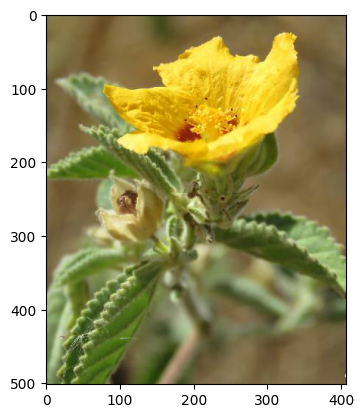

In [28]:
idx = 178884122
img = cv2.imread(f'./data/train_images/{idx}.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

box = full_valid.loc[idx, 'box']
patch = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
plt.imshow(patch)

In [29]:
full_train.to_csv('./data/processed/train.csv')
full_valid.to_csv('./data/processed/valid.csv')
dump(scaler, './data/processed/scaler.joblib')

['./data/processed/scaler.joblib']

In [30]:
test = pd.read_csv('./data/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'./data/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('./data/test.pkl')

Exception ignored in: <_io.FileIO name='./data/test_images/201238668.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_2036\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/202310319.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_2036\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/202604412.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_2036\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/201353439.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_2036\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/195351745.jpeg' mode='rb' closefd

In [31]:
x_feature = train.columns[:-12].tolist()

In [32]:
train_scaler = MinMaxScaler()
x_train = np.zeros_like(train[x_feature], dtype=np.float32)

for idx, target in enumerate(x_feature):
    v = train[target].values

    # if target in log_x_features:
    #     v = np.log10(v)

    x_train[:, idx] = v

x_train = train_scaler.fit_transform(x_train)

In [33]:
x_train = pd.DataFrame(x_train, columns=x_feature).set_index(train.index)

In [34]:
x_train

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
id,,,,,,,,,,,,,,,,,,,,,
192027691,0.589813,0.044619,0.025531,0.426087,0.378824,0.457493,0.581818,0.705480,0.591195,0.714286,...,0.575114,0.626286,0.664685,0.617829,0.508444,0.492431,0.527086,0.563307,0.550562,0.509584
195542235,0.704175,0.010753,0.004227,0.225383,0.421284,0.577709,0.575758,0.671233,0.603774,0.700000,...,0.345149,0.329614,0.328575,0.293476,0.287068,0.288866,0.306226,0.329012,0.357319,0.390336
196639184,0.635668,0.107486,0.020271,0.105398,0.187548,0.270513,0.472727,0.595890,0.484277,0.578571,...,0.550643,0.542005,0.557043,0.547241,0.508091,0.505871,0.527450,0.542260,0.563369,0.577594
195728812,0.736208,0.175626,0.066600,0.265415,0.184114,0.228183,0.551515,0.582192,0.522013,0.614286,...,0.418259,0.402210,0.393359,0.368121,0.365837,0.381258,0.375098,0.415178,0.426880,0.439240
195251545,0.327181,0.063162,0.020767,0.225440,0.651606,0.682751,0.375758,0.684932,0.490566,0.664286,...,0.449685,0.516819,0.582126,0.683623,0.697561,0.714746,0.672821,0.583382,0.562210,0.568153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190558785,0.754182,0.029169,0.015977,0.395528,0.229578,0.358935,0.539394,0.643836,0.559748,0.650000,...,0.352887,0.360968,0.387108,0.386940,0.383697,0.404191,0.415855,0.392167,0.369852,0.366528
194523231,0.623621,0.172774,0.066257,0.254386,0.318866,0.339930,0.581818,0.671233,0.584906,0.685714,...,0.365096,0.375305,0.404186,0.391818,0.391281,0.390929,0.384000,0.383039,0.372647,0.368793
195888987,0.646723,0.069332,0.044603,0.526424,0.246722,0.343149,0.539394,0.746575,0.591195,0.721429,...,0.212316,0.206358,0.205448,0.181755,0.168654,0.170534,0.171084,0.169653,0.168127,0.177631


In [35]:
x_train_feats = x_train.loc[targets.index, :]
x_val_feats = x_train.loc[val_targets.index, :]

In [36]:
x_train_feats.to_csv('./data/processed/train_x.csv')
x_val_feats.to_csv('./data/processed/valid_x.csv')

In [37]:
dump(train_scaler, './data/processed/scaler_x.joblib')

['./data/processed/scaler_x.joblib']